In [5]:
import re
import string
import spacy
import nltk
from datasets import load_dataset
from nltk.corpus import stopwords

# Stopwords from NLTK
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Spacy model
nlp = spacy.load("en_core_web_sm")

# Text preprocessing 
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r"<.*?>", "", text)  
    text = re.sub(r"\d+", "", text)  
    text = text.translate(str.maketrans("", "", string.punctuation))  
    text = re.sub(r"\s+", " ", text).strip()  

    # Tokenization, stopword removal, and lemmatization
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]

    return " ".join(tokens)

#Dataset load
dataset = load_dataset("imdb")

dataset = dataset.map(lambda x: {"text": preprocess_text(x["text"])})

# Example of preprocessed text
print(dataset["train"][:5])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'text': ['rent curiousyellow video store controversy surround first release also hear first seize we customs ever try enter country therefore fan film consider controversial really see myselfthe plot center around young swedish drama student name lena want learn everything life particular want focus attention make sort documentary average swede think certain political issue vietnam war race issue united states ask politician ordinary denizen stockholm opinion politic sex drama teacher classmate marry menwhat kill curiousyellow year ago consider pornographic really sex nudity scene far even shoot like cheaply make porno countryman mind find shock reality sex nudity major staple swedish cinema even ingmar bergman arguably answer good old boy john ford sex scene filmsi commend filmmaker fact sex show film show artistic purpose rather shock people make money show pornographic theater america curiousyellow good film anyone want study meat potato pun intend swedish cinema really film not mu

In [6]:
from collections import Counter

print("First 20 labels:", dataset["train"]["label"][:20])
print("Unique labels:", set(dataset["train"]["label"]))
print("Label distribution:", Counter(dataset["train"]["label"]))


First 20 labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Unique labels: {0, 1}
Label distribution: Counter({0: 12500, 1: 12500})


Cosine similarity (CBOW): 0.81304085
Cosine similarity (SkipGram): 0.9090091


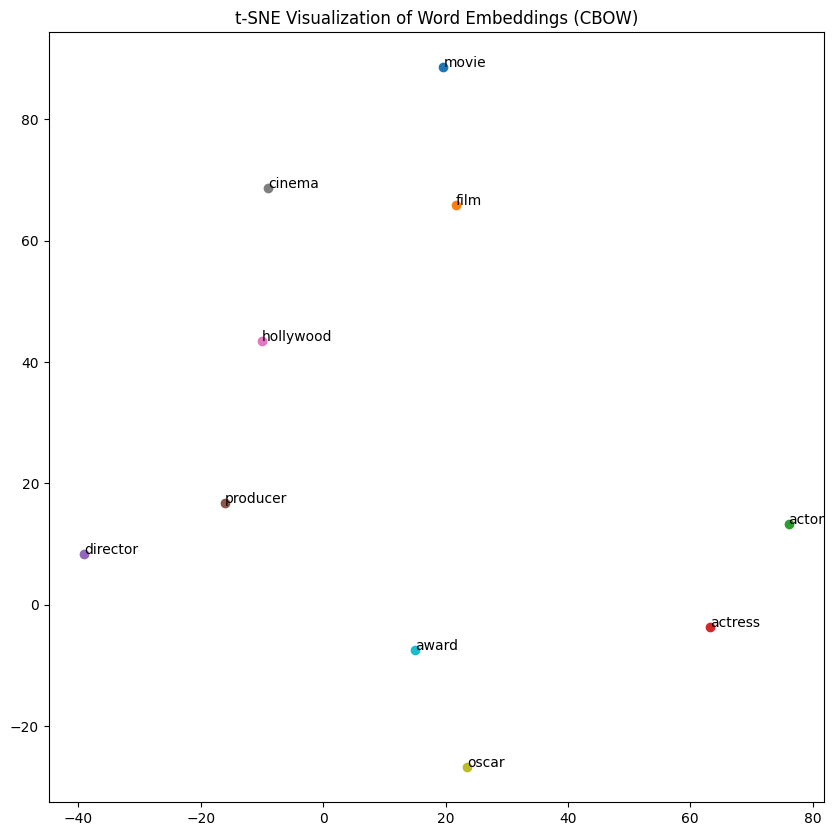

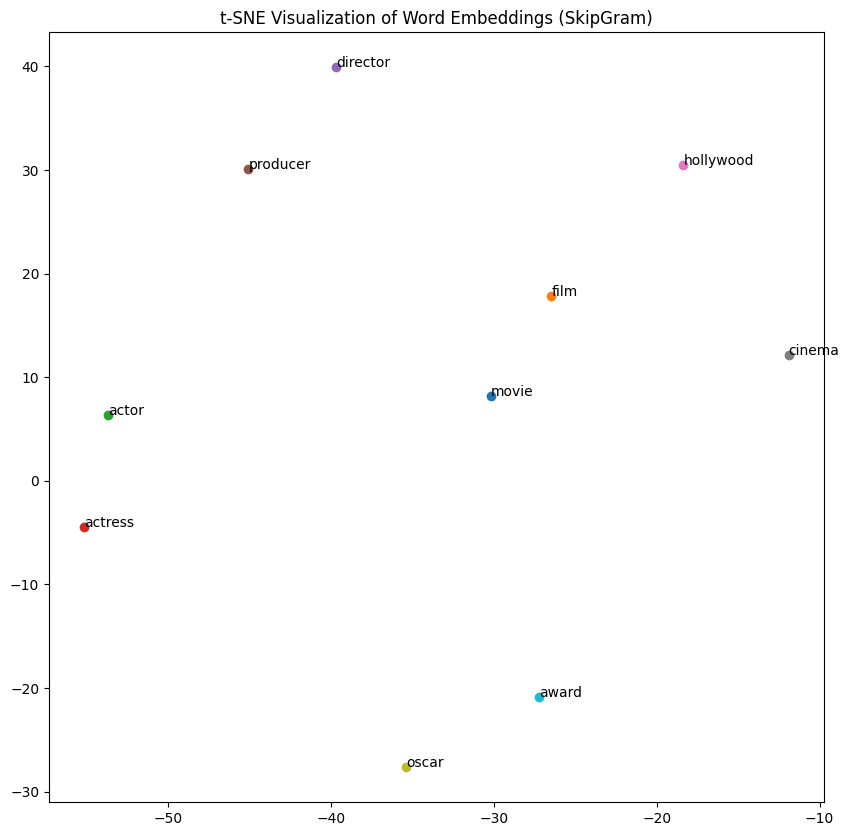

In [32]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine

tokenized_texts = [text.split() for text in dataset["train"]["text"]]
#Create CBOW Model
cbow_model = gensim.models.Word2Vec(sentences=tokenized_texts, min_count=1, vector_size=100, window=5)
    
# Skip-gram Model
skipgram_model = gensim.models.Word2Vec(sentences=tokenized_texts, min_count=1, vector_size=100, window=5, sg=1)


print("Cosine similarity (CBOW):", cbow_model.wv.similarity("movie", "film"))
print("Cosine similarity (SkipGram):", skipgram_model.wv.similarity("movie", "film"))
def visualize_embeddings_tsne(model, words, method):
    word_vectors = np.array([model.wv[word] for word in words]) 
    reducer = TSNE(n_components=2, perplexity=5, random_state=42)
    reduced_vectors = reducer.fit_transform(word_vectors)
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    if method == 'CBOW':
        plt.title("t-SNE Visualization of Word Embeddings (CBOW)")
    else:   
        plt.title("t-SNE Visualization of Word Embeddings (SkipGram)")
    plt.show()
most_used_words = ["movie", "film", "actor", "actress", "director", "producer", "hollywood", "cinema", "oscar", "award"]
visualize_embeddings_tsne(cbow_model, most_used_words, 'CBOW')
visualize_embeddings_tsne(skipgram_model, most_used_words, 'SkipGram')


Text embeddings (GloVe) shape: (25000, 100)
Cosine similarity (GloVe): 0.9055121759629844


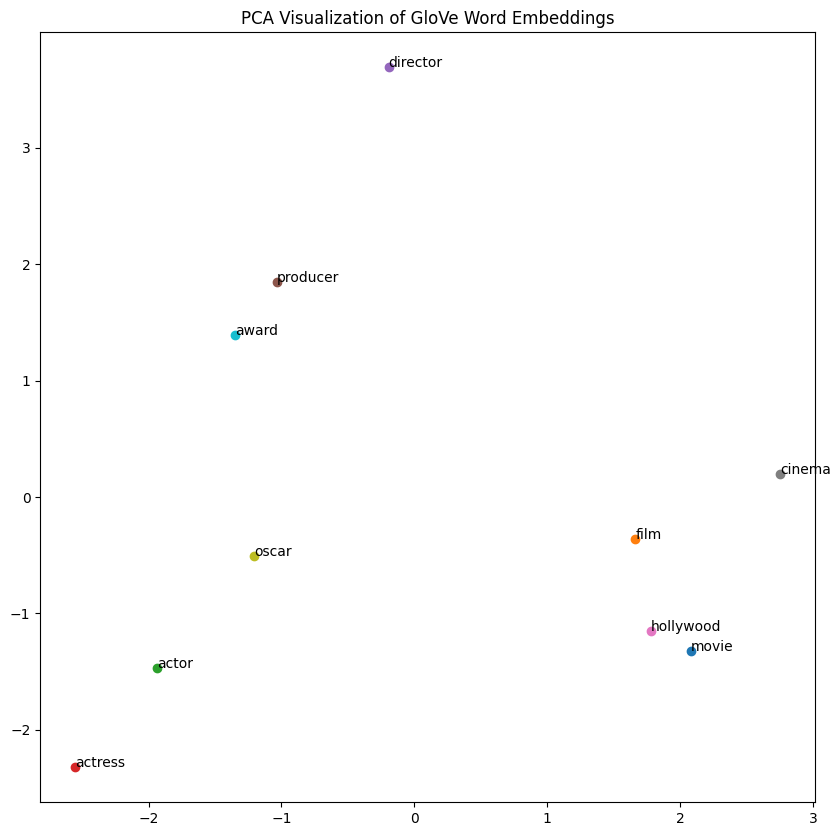

In [8]:
#Glove
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
glove_p = "glove.6B.100d.txt"


glove = {}

with open(glove_p, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        glove[word] = vector

def text_to_glove(text, glove):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    if len(vectors) == 0:
        return np.zeros(100)
    return np.mean(vectors, axis=0)
text_vectors_glove = np.array([text_to_glove(text, glove) for text in dataset["train"]["text"]])
print("Text embeddings (GloVe) shape:", text_vectors_glove.shape)  


print("Cosine similarity (GloVe):", 1 - cosine(glove["movie"], glove["film"]))

def visualize_glove_pca(words):
    word_vectors = np.array([glove[word] for word in words])
    reducer = PCA(n_components=2)
    reduced_vectors = reducer.fit_transform(word_vectors)
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

    plt.title("PCA Visualization of GloVe Word Embeddings")
    plt.show()
visualize_glove_pca(most_used_words)

Text embeddings (FastText) shape: (25000, 300)
Cosine similarity (FastText): 0.876942216801765


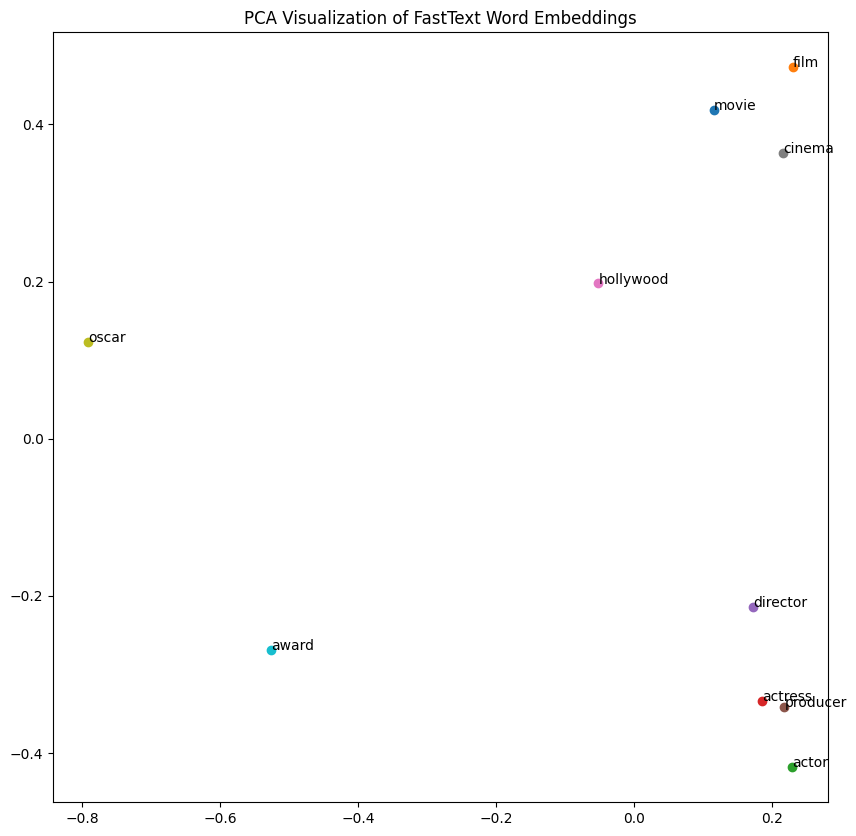

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import gensim.downloader as api

# Pretrained model
ft = api.load("fasttext-wiki-news-subwords-300")

def text_to_fasttext(text, ft):
    words = text.split()
    vectors = [ft[word] for word in words if word in ft]
    if len(vectors) == 0:
        return np.zeros(300)
    return np.mean(vectors, axis=0)
text_vectors_ft = np.array([text_to_fasttext(text, ft) for text in dataset["train"]["text"]])
print("Text embeddings (FastText) shape:", text_vectors_ft.shape)


print("Cosine similarity (FastText):", 1 - cosine(ft["movie"], ft["film"]))


def visualize_fasttext_pca(words):
    word_vectors = np.array([ft[word] for word in words])
    reducer = PCA(n_components=2)
    reduced_vectors = reducer.fit_transform(word_vectors)

    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

    plt.title("PCA Visualization of FastText Word Embeddings")
    plt.show()

visualize_fasttext_pca(most_used_words)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN_Layer (SimpleRNN)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 144ms/step - accuracy: 0.6053 - loss: 0.6773 - val_accuracy: 0.0000e+00 - val_loss: 1.0810
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.6216 - loss: 0.6641 - val_accuracy: 0.0000e+00 - val_loss: 1.0300
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.6251 - loss: 0.6620 - val_accuracy: 0.0000e+00 - val_loss: 1.0266
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - accuracy: 0.6250 - loss: 0.6618 - val_accuracy: 0.0000e+00 - val_loss: 1.0281
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.6256 - loss: 0.6616 - val_accuracy: 0.0000e+00 - val_loss: 1.0272
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.6261 - loss: 0.6615 - val_accuracy: 0.0000e+00 - val_loss: 1.0279
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.6266 - loss: 0.6612 - val_accuracy: 6.0000e-04 - val_loss: 1.0286
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step 

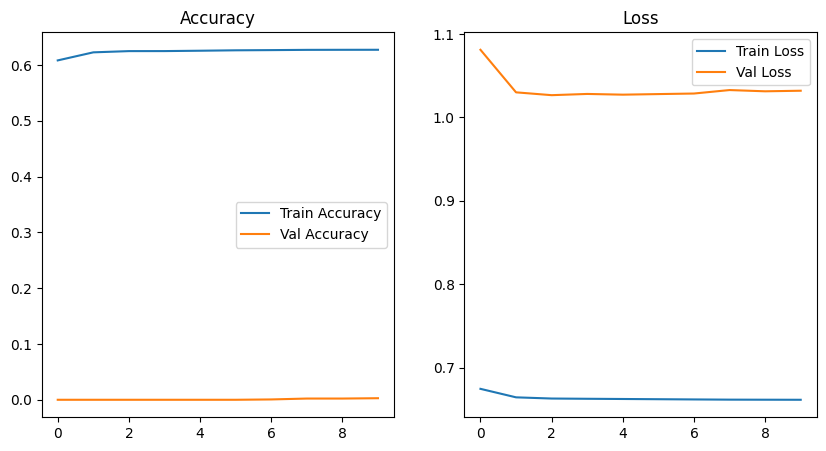

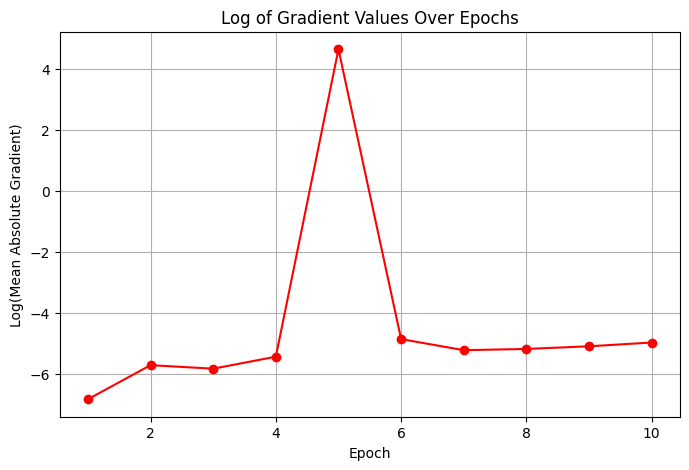

In [37]:
# 2 task

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

np.random.seed(42)
tf.random.set_seed(42)

# Параметры
max_len = 500  
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")
tokenizer.fit_on_texts(dataset["train"]["text"])

tokenized_texts = tokenizer.texts_to_sequences(dataset["train"]["text"])
padded_sequences = pad_sequences(tokenized_texts, maxlen=max_len, padding="post", truncating="post")

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(SimpleRNN(128, return_sequences=True, name="RNN_Layer")) 
model.add(SimpleRNN(64))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

labels = np.array(dataset["train"]["label"], dtype=np.float32)

history = model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

def get_gradients_during_training(model, dataset, epochs=10):
    grad_means = []
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    batch_data_x = padded_sequences[:32]
    batch_data_y = np.array(dataset["train"]["label"][:32], dtype=np.float32).reshape(-1, 1)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            predictions = model(batch_data_x, training=True)
            loss = tf.keras.losses.binary_crossentropy(batch_data_y, predictions)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        rnn_gradients = gradients[2].numpy().flatten()
        grad_means.append(np.log(np.mean(np.abs(rnn_gradients) + 1e-10)))
        
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return grad_means

gradients_over_epochs = get_gradients_during_training(model, dataset, epochs=10)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), gradients_over_epochs, marker='o', linestyle='-', color='red')
plt.xlabel("Epoch")
plt.ylabel("Log(Mean Absolute Gradient)")
plt.title("Log of Gradient Values Over Epochs")
plt.grid()
plt.show()



LSTM
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.6448 - loss: 0.6509 - val_accuracy: 0.4394 - val_loss: 0.9521
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6969 - loss: 0.5977 - val_accuracy: 0.6126 - val_loss: 0.8878
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6937 - loss: 0.5740 - val_accuracy: 0.6352 - val_loss: 0.6903
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.8697 - loss: 0.3240 - val_accuracy: 0.6758 - val_loss: 0.7919
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9072 - loss: 0.2394 - val_accuracy: 0.7454 - val_loss: 0.6238
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9317 - loss: 0.1835 - val_accuracy: 0.6068 - val_loss: 1.0448
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9495 - loss: 0.1449 - val_accuracy: 0.6306 - val_loss: 1.1758
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9663 - loss: 0.10

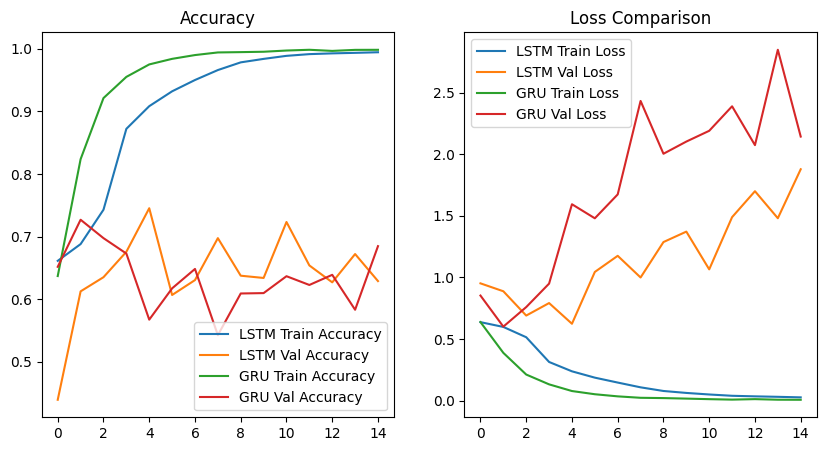

LSTM Time: 396.78440046310425
GRU Time: 418.8056962490082
LSTM Final Accuracy: 0.6290000081062317
GRU Final Accuracy: 0.6848000288009644


In [31]:
# 3task
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
import matplotlib.pyplot as plt
import time
from collections import Counter

max_len = 100      
max_words = 10000   


tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")

tokenizer.fit_on_texts(dataset["train"]["text"])

tokenized_texts = tokenizer.texts_to_sequences(dataset["train"]["text"])
padded_sequences = pad_sequences(tokenized_texts, maxlen=max_len, padding="post", truncating="post")
labels = np.array(dataset["train"]["label"], dtype=np.float32)
print("LSTM")

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1, activation="sigmoid"))
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
start_time = time.time()
lstm_history = lstm_model.fit(padded_sequences, labels, epochs=15, batch_size=32, validation_split=0.2)
lstm_time = time.time() - start_time

print("GRU")

gru_model = Sequential()
gru_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len)) 
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(GRU(32))
gru_model.add(Dense(1, activation="sigmoid"))
gru_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
start_time = time.time()
gru_history = gru_model.fit(padded_sequences, labels, epochs=15, batch_size=32, validation_split=0.2)
gru_time = time.time() - start_time

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history["accuracy"], label="LSTM Train Accuracy")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM Val Accuracy")
plt.plot(gru_history.history["accuracy"], label="GRU Train Accuracy")
plt.plot(gru_history.history["val_accuracy"], label="GRU Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history["loss"], label="LSTM Train Loss")
plt.plot(lstm_history.history["val_loss"], label="LSTM Val Loss")
plt.plot(gru_history.history["loss"], label="GRU Train Loss")
plt.plot(gru_history.history["val_loss"], label="GRU Val Loss")
plt.legend()
plt.title("Loss Comparison")
plt.show()

print("LSTM Time:", lstm_time)
print("GRU Time:", gru_time)

lstm_final_accuracy = lstm_history.history["val_accuracy"][-1]
gru_final_accuracy = gru_history.history["val_accuracy"][-1]

print("LSTM Final Accuracy:", lstm_final_accuracy)
print("GRU Final Accuracy:", gru_final_accuracy)



In [38]:
# 4 task
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from collections import Counter

flowers_for_algernon_sentences = [
    "To be, or not to be, that is the question.",
    "All the world’s a stage, and all the men and women merely players.",
    "Some are born great, some achieve greatness, and some have greatness thrust upon them.",
    "There is nothing either good or bad, but thinking makes it so.",
    "The lady doth protest too much, methinks.",
    "Cowards die many times before their deaths; the valiant never taste of death but once.",
    "What’s in a name? That which we call a rose by any other name would smell as sweet.",
    "Brevity is the soul of wit.",
    "This above all: to thine own self be true.",
    "Though she be but little, she is fierce.",
    "The course of true love never did run smooth.",
    "Love all, trust a few, do wrong to none.",
    "The fault, dear Brutus, is not in our stars, but in ourselves.",
    "Better three hours too soon than a minute too late.",
    "Nothing will come of nothing.",
    "Uneasy lies the head that wears a crown.",
    "Hell is empty and all the devils are here.",
    "We are such stuff as dreams are made on, and our little life is rounded with a sleep.",
    "Speak low if you speak love.",
    "How far that little candle throws his beams! So shines a good deed in a naughty world.",
    "Our doubts are traitors, and make us lose the good we oft might win, by fearing to attempt.",
    "The evil that men do lives after them; the good is oft interred with their bones.",
    "Wisely and slow; they stumble that run fast.",
    "Expectation is the root of all heartache.",
    "Give every man thy ear, but few thy voice.",
    "One may smile, and smile, and be a villain.",
    "Fortune brings in some boats that are not steered.",
    "Love is not love which alters when it alteration finds.",
    "Sweet are the uses of adversity.",
    "When sorrows come, they come not single spies, but in battalions.",
    "I am not bound to please thee with my answers.",
    "Good night, good night! Parting is such sweet sorrow, that I shall say good night till it be morrow."
]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(flowers_for_algernon_sentences)
total_words = len(tokenizer.word_index) + 1 

input_sequences = []
for flower_for_algernon_sentence in flowers_for_algernon_sentences:
    token_list = tokenizer.texts_to_sequences([flower_for_algernon_sentence])[0]
    for i in range(1, len(token_list)):
        input_sequences.append(token_list[:i+1])

max_sequence_length = max([len(seq) for seq in input_sequences])+4
padded_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
x, y = padded_sequences[:, :-1], padded_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)


l_model = Sequential()
l_model.add(Embedding(total_words, 150, input_length=max_sequence_length-1))   
l_model.add(LSTM(150))
l_model.add(Dropout(0.4))
l_model.add(Dense(200, activation='relu'))
l_model.add(Dropout(0.4))
l_model.add(Dense(total_words, activation='softmax'))

l_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])      
l_model.fit(x, y, epochs=100, verbose=1)

def generate_text(seed_text, next_words=20, max_repeats=1):
    generated_text = seed_text
    word_counts = Counter()
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length - 1, padding='pre')
        predicted_probs = l_model.predict(token_list, verbose=0)[0]
        
        top_n = np.argsort(predicted_probs)[-3:]
        top_probs = predicted_probs[top_n]
        top_probs /= np.sum(top_probs)
        predicted = np.random.choice(top_n, p=top_probs)
        
        output_word = tokenizer.index_word.get(predicted, "")
        if word_counts[output_word] >= max_repeats:
            continue
        
        generated_text += " " + output_word
    
    return generated_text

seeds = ["Some", "Love", "I will", "The", "You can't", "Memento", "The only way", "To be", "Sometimes you win", "It is not the years"]
for seed in seeds:
    print(f"Generated text for '{seed}':\n{generate_text(seed)}\n")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 8.9286e-04 - loss: 5.3097
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0466 - loss: 5.2794
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0500 - loss: 5.1374
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0365 - loss: 4.9585
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0337 - loss: 4.9544
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0284 - loss: 4.9191
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0363 - loss: 4.8983
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0387 - loss: 4.9054
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0497 - loss: 4.8495
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0316 - loss: 4.7534
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0733 - loss: 4.6917
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

Bidirectional LSTM
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.7168 - loss: 0.5695 - val_accuracy: 0.4918 - val_loss: 1.0120
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.9050 - loss: 0.2449 - val_accuracy: 0.6040 - val_loss: 0.7895
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.9456 - loss: 0.1505 - val_accuracy: 0.7534 - val_loss: 0.6546
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.9665 - loss: 0.0946 - val_accuracy: 0.6504 - val_loss: 1.2291
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9745 - loss: 0.0721 - val_accuracy: 0.7128 - val_loss: 1.1580
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9813 - loss: 0.0549 - val_accuracy: 0.6876 - val_loss: 1.3438


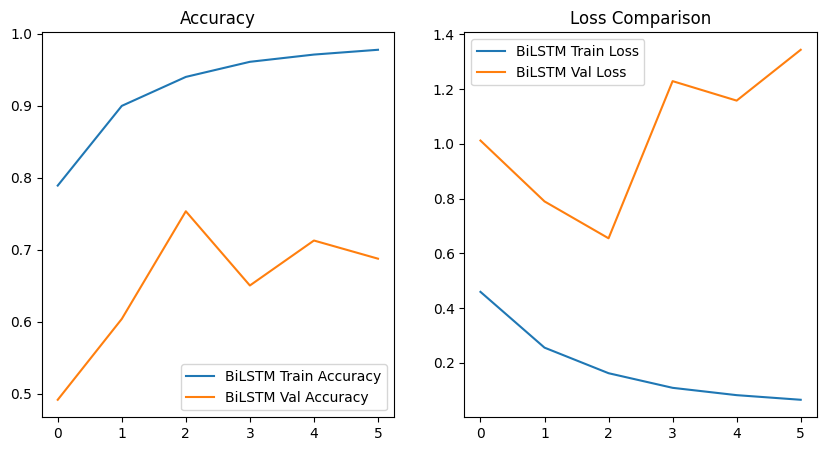

BiLSTM Time: 210.34886527061462
BiLSTM Final Accuracy: 0.7534000277519226


In [ ]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

max_len = 100      
max_words = 10000   

# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")
tokenizer.fit_on_texts(dataset["train"]["text"])
tokenized_texts = tokenizer.texts_to_sequences(dataset["train"]["text"])
padded_sequences = pad_sequences(tokenized_texts, maxlen=max_len, padding="post", truncating="post")
labels = np.array(dataset["train"]["label"], dtype=np.float32)

print("Bidirectional LSTM")

# Bidirectional LSTM Model
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bilstm_model.add(BatchNormalization())  
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(1, activation="sigmoid"))

bilstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

start_time = time.time()
bilstm_history = bilstm_model.fit(
    padded_sequences, labels, 
    epochs=15, batch_size=32, validation_split=0.2, 
    callbacks=[early_stopping]
)
bilstm_time = time.time() - start_time

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM Train Accuracy")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(bilstm_history.history["loss"], label="BiLSTM Train Loss")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM Val Loss")
plt.legend()
plt.title("Loss Comparison")
plt.show()

print("BiLSTM Time:", bilstm_time)
print("BiLSTM Final Accuracy:", max(bilstm_history.history["val_accuracy"]))
